### 분석 단위 및 대상

    - 대상: 서울시 25개 자치구

    - 기간: 2023년 기준

    - 분석 단위: 자치구별 수치

### 사회불안지표 변수 구성


    - 구조적 요인:  1인가구_비율, 외국인비율, 학업중단율(중/고) - 지역 내 사회적 고립, 취약성

    - 정서적 요인:  우울감 경험률, 자살률 - 지역민의 심리적 안정도

    - 사회참여:  봉사활동 등록률 (역정규화) - 공동체 활동 부족은 불안 요인 가능

    - 기타:  이혼율 등 (선택적으로 사용) - 가족 구조 붕괴 지표


In [2]:
# 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 기본 테마 설정
# https://coldbrown.co.kr/2023/07/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EC%8B%A4%EC%A0%84%ED%8E%B8-08-seaborn-sns-set%EC%9D%84-%ED%86%B5%ED%95%B4-%EC%8A%A4%ED%83%80%EC%9D%BC-%EC%84%A4%EC%A0%95%ED%95%98%EA%B8%B0/
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 복잡한 통계 처리를 위한 라이브러리
from scipy import stats

# 필요한 패키지
import os

In [3]:
# 현재 경로 확인
os.getcwd()


'c:\\Users\\admin\\Desktop\\mid_project\\MidProject\\members\\조준혁\\notebook'

In [4]:

# 상위 폴더로 이동
os.chdir('../../')

In [5]:
os.chdir(r'C:/Users/admin/Desktop/mid_project/MidProject')

In [6]:
# 현재 경로 확인
os.getcwd()


'C:\\Users\\admin\\Desktop\\mid_project\\MidProject'

In [7]:
# 정규화용 라이브러리
from sklearn.preprocessing import MinMaxScaler

In [8]:
import statsmodels.api as sm

In [9]:
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression


‘마계’란 은어로 범죄 등 사회 문제가 심각한 지옥 같은 지역을 판타지 소설이나 게임 등에서 흔히 등장하는 악마, 혹은 마족이 살아가는 땅 마계에 비유한 것이다.
서울특별시 25개 자치구 중 가장 ‘마계’에 어울리는 구는 어디인가? 이는 단순히 범죄 발생 건수가 많다는 것뿐만 아니라, 사회적 불안 요인(1인 가구 비율, 외국인 주민 비율, 청년층 인구 비율, 주거 환경, 실업률 등)이 복합적으로 열악하여 범죄와 사회 불안이 동시에 높다는 것을 의미한다. 

인구 규모 차이를 고려해 실제로 어느 구가 더 위험한지 판단하기 위해 단순 발생 건수뿐 아니라 범죄율을 볼 것이다.

- 사회적 불안 요인: 데이터에서 추출 가능한 여러 지표 중 1인 가구 비율, 외국인 주민 비율, 청년층(청년 인구) 비율, 실업률 등을 고려했다.

- 가설 수립: 각 요인과 범죄 사이에 상관관계가 있을 것이다.
    - 1인 가구 비율이 높을수록 범죄 발생률이 높을 것이다
    - 실업률이 높은 지역일수록 범죄가 많을 것이다
    - 외국인이 많을 수록 범죄가 많을 것이다. (문화적 다양성은 사회의 응집력이 낮출 수 있다는 가정임)
    

- EDA 시각화: 자치구별 범죄와 사회 요인을 다양한 그래프로 시각화하여 분포와 상관성, 특이점을 살피고,
- 범죄 발생률 상위 지역, 각 요인별 상위 지역을 비교하고 **상관관계 그래프(산점도, 히트맵 등)**를 통해 어떤 요인이 범죄와 밀접한지 파악한다.

- ‘마계’ 정의 기준 설정: 위 분석을 바탕으로 범죄와 여러 불안 요인에서 전반적으로 높은 점수를 보이는 자치구를 ‘마계’ 후보로 선정한다. 즉 범죄 발생률도 높고 1인 가구 등 사회적 취약 지표도 높은 지역이 최종적으로 가장 ‘마계’에 가까운 지역으로 판단될 것.

In [17]:
# 데이터 불러오기
merged10_df = pd.read_csv('members/조준혁/궁극머지데이터.csv')
merged10_df.head()

,Unnamed: 0,자치구별,인구소계,봉사활동 등록률,이혼율,1인가구수(남자),1인가구수(여자),1인가구수(남녀총합),초등학교 학업중단율,중학교 학업중단율,...,외국인비율,총범죄율,강력범죄율,가구-계 (가구),정신의료기관수,정신의료기관 병상 수,정신의료기관비율,병상 수 비율,우울감경험율,2023 실업률
0,0,종로구,139417,45.09,1.43,14040,15294,29334,2.09,1.37,...,8.020543,6615.405582,180.035433,70217,27,83,19.366361,59.533629,7.2,3.4
1,1,중구,121312,33.53,1.62,13574,14719,28293,2.64,1.73,...,8.589422,8072.573200,196.188341,64325,21,20,17.310736,16.486415,6.9,3.1
2,2,용산구,213151,26.23,1.46,19436,23046,42482,4.18,1.96,...,6.821455,4242.063138,124.794160,103826,9,21,4.222359,9.852171,7.0,3.5
3,3,성동구,277361,27.77,1.23,23464,24647,48111,1.91,0.85,...,2.587602,2656.105220,46.149242,127950,17,33,6.129196,11.897852,7.0,3.1
4,4,광진구,335554,27.17,1.34,34355,37604,71959,1.43,1.08,...,4.576015,2887.165702,74.801671,168848,25,342,7.450366,101.921002,10.2,3.7


## 자치구별 범죄 발생 현황

- 시작하기에 앞서 인구 수를 살펴보겠다.

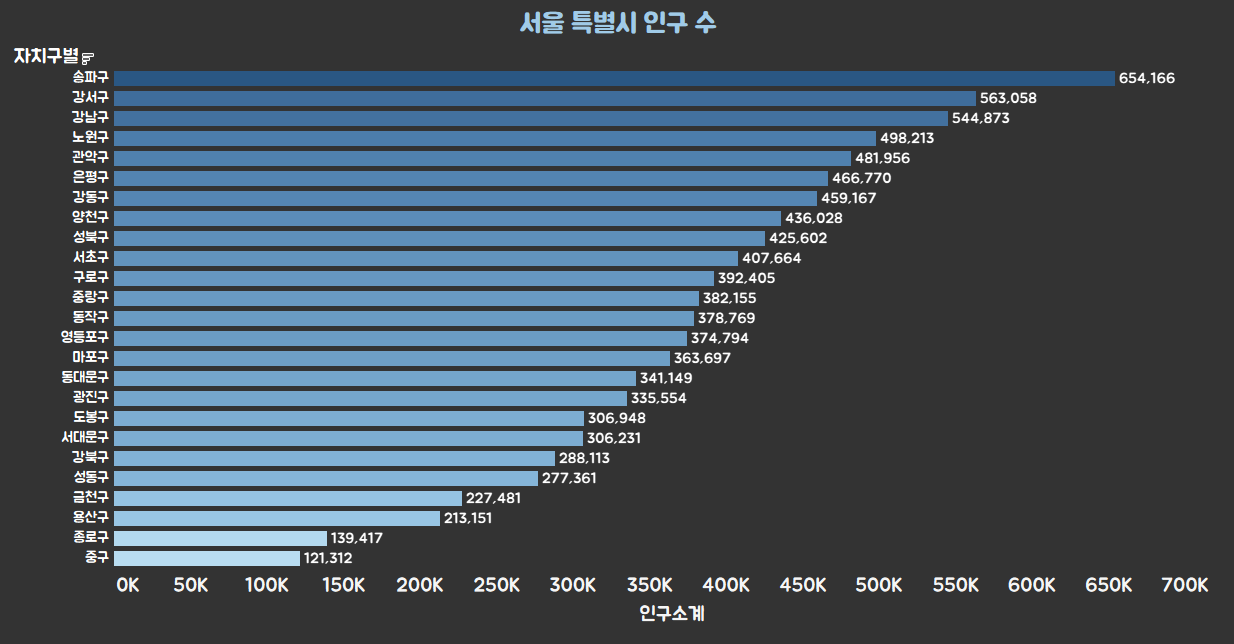

2023년 기준 송파구, 강서구, 강남구, 노원구, 관악구 순으로 인구가 많은 것을 확인할 수 있다. 

### 자치구별 범죄 발생 수준을 살펴보겠다.

- 각 구의 범죄 총 발생 건수를 비교

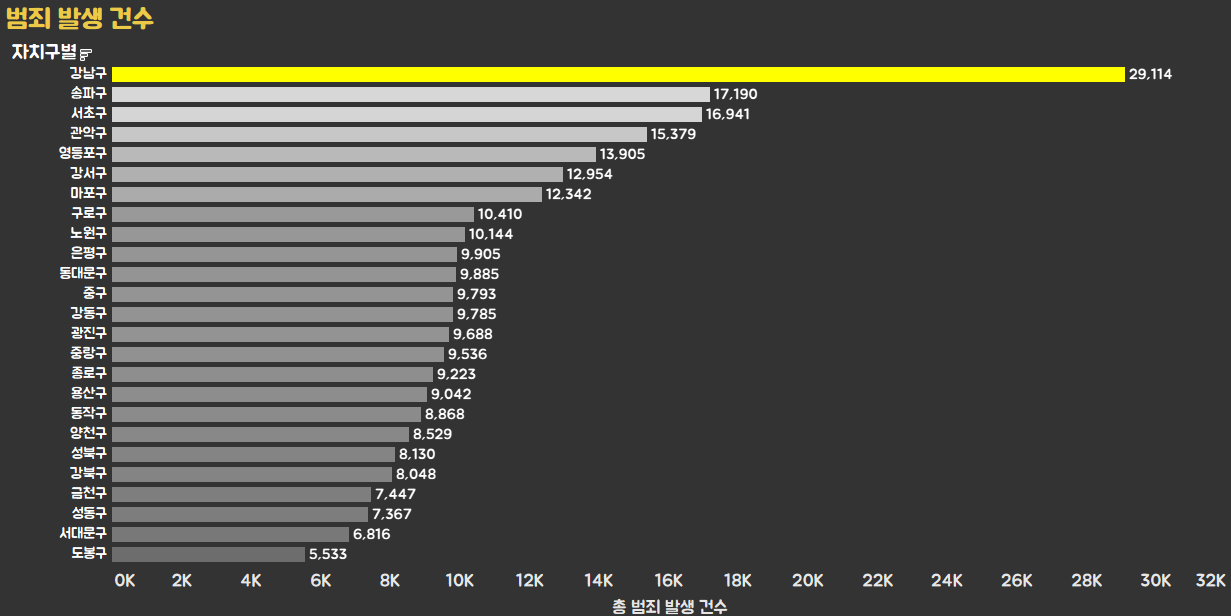

- 범죄 발생 “건수”만 보면, 인구가 많은 자치구들이 상위권을 차지한다. 특히 강남구는 연간 발생건수가 가장 많았고, 송파구, 서초구, 관악구 등도 범죄 발생건수가 높은 편이었다

- 강력범죄 발생 건수 비교

        경찰청의 범죄 발생 지역별 통계 데이터에서는 살인, 강도, 강간, 강제추행, 기타강간강제추행, 방화를 묶어 강력범죄라고 정의한다. 
        일반적으로 폭행과 절도를 묶어 5대 범죄, 5대 강력범죄라고 부르기도 하지만 경찰청에서는 상해, 폭행, 감금 등을 폭력범죄로 분류하며 
        절도는 절도범죄로 분류한다. 

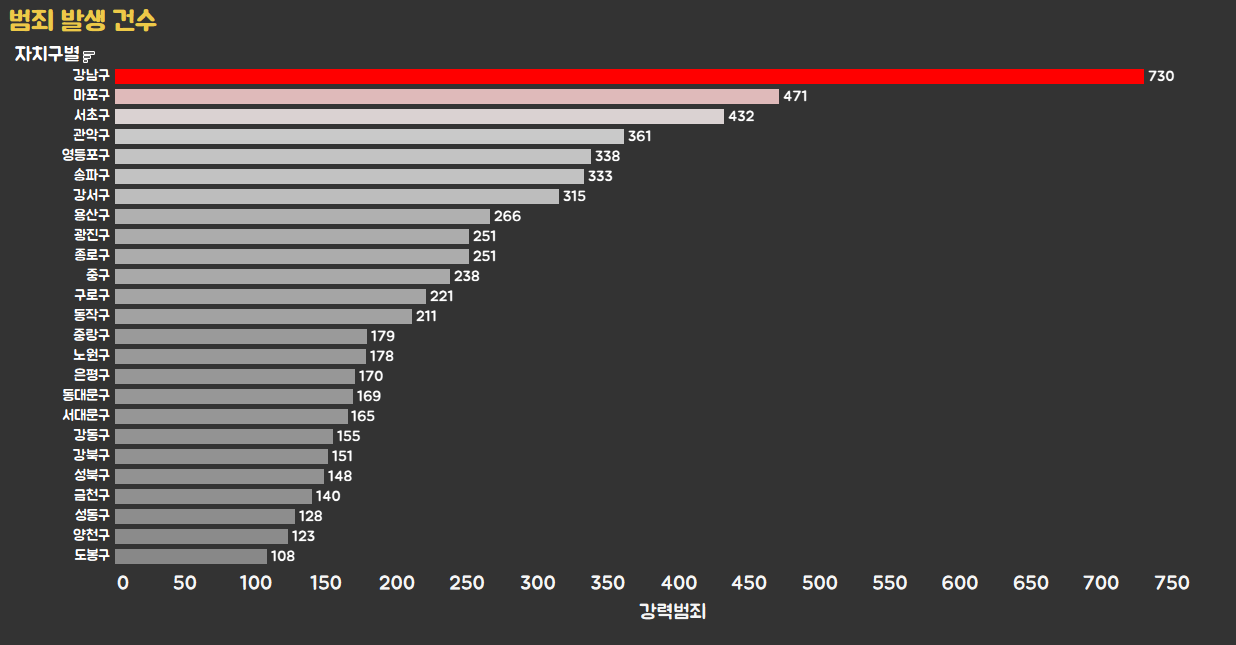

2023년 데이터 기준 강남구의 강력범죄 발생 건수는 730건으로 최다 수준이다. 이는 강남구의 인구가 많기 때문으로 추측할 수 있다
반면 마포구는 인구 수가 상대적으로 많지 않지만 강력범죄 건수가 매우 많다. 

- 범죄 발생 “율”(인구 대비 발생률)을 보면 결과가 다소 다르다

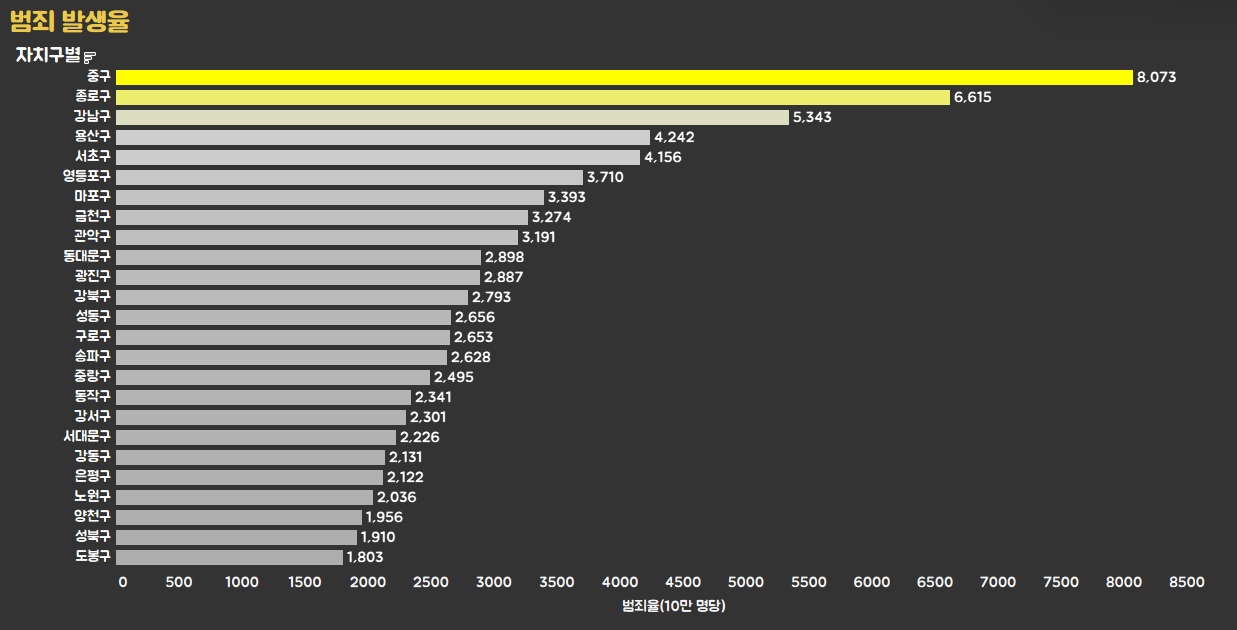

인구 10만 명당 범죄 발생률이 가장 높은 곳들은 중구, 종로구 등의 도심지역으로 나타났다.
노원구는 발생 건수는 중상위권이지만 인구가 많아 10만 명당 범죄율은 비교적 낮게 나왔다
송파구는 발생 건수는 많으나 인구대비 범죄율은 중하위 수준에 그쳤다. 

범죄 “발생건수”만 볼 경우 강남구가 최다 등 인구 규모 영향이 컸다. 그러나 **“발생률”**을 보면 중구, 종로구 등이 더 두드러졌다. 따라서 절대 발생 건수와 인구 대비 발생률을 모두 고려해야 지역의 위험성을 제대로 평가할 수 있을 것이다.

### 범죄와 사회 요인의 상관관계 분석

- EDA를 통해 각 변수와 범죄 발생률 간 관계를 산점도와 상관계수로 검토, 유의미한 패턴과 예외를 분석

#### 1인 가구 비율과 범죄

가설: 가족보다 1인 가구가 많은 지역일수록 범죄에 취약할 가능성이 높다. 1인 가구는 공동체 감시 약화, 사회적 고립 등의 이유로 범죄 표적이 되기 쉽고, 특히 청년 1인 가구 밀집 지역에서 범죄가 증가한다는 보도도 있다. 

https://www.newsis.com/view/NISX20250514_0003175378#:~:text=%5B%EB%8B%A8%EB%8F%85%5D%EA%B5%90%EC%A0%9C%ED%8F%AD%EB%A0%A5%C2%B7%EC%8A%A4%ED%86%A0%ED%82%B9%E2%80%A61%EC%9D%B8%EA%B0%80%EA%B5%AC%20%EB%B0%80%EC%A7%91%20%27%EC%98%81%EB%93%B1%ED%8F%AC,%EC%A4%91%20%EA%B4%80%EC%95%85%EA%B5%AC%EB%8A%94%20%EC%84%9C%EC%9A%B8%2025%EA%B0%9C

### 정규화를 진행한다

- 변수 간의 스케일 차이를 제거하고, 분석 결과의 왜곡을 방지하기 위해 정규화를 수행하였다

In [11]:
cols_to_normalize = ['인구 비율','총범죄율', '강력범죄율','이혼율', '소계(10만명당자살률)', '1인가구_비율', '1인가구_비율(여성)' , '1인가구_비율(남성)','봉사활동 등록률', '외국인비율','청소년비행_비율', '초등학교 학업중단율', '중학교 학업중단율', '고등학교 학업중단율', '정신의료기관비율','병상 수 비율','우울감경험율', '2023 실업률']

df_norm3 = merged10_df.copy()


# 정규화
scaler = MinMaxScaler()
df_norm3[cols_to_normalize] = scaler.fit_transform(df_norm3[cols_to_normalize])

# 봉사활동 역정규화
df_norm3['봉사활동_역정규화'] = 1 - df_norm3['봉사활동 등록률']

In [12]:
df_norm3.head()

,Unnamed: 0,자치구별,인구소계,봉사활동 등록률,이혼율,1인가구수(남자),1인가구수(여자),1인가구수(남녀총합),초등학교 학업중단율,중학교 학업중단율,...,총범죄율,강력범죄율,가구-계 (가구),정신의료기관수,정신의료기관 병상 수,정신의료기관비율,병상 수 비율,우울감경험율,2023 실업률,봉사활동_역정규화
0,0,종로구,139417,1.000000,0.558824,14040,15294,29334,0.447090,0.476395,...,0.767596,0.903840,70217,27,83,0.913512,0.262401,0.369231,0.340426,0.000000
1,1,중구,121312,0.501509,0.838235,13574,14719,28293,0.592593,0.630901,...,1.000000,1.000000,64325,21,20,0.799248,0.072666,0.323077,0.212766,0.498491
2,2,용산구,213151,0.186718,0.602941,19436,23046,42482,1.000000,0.729614,...,0.389072,0.574982,103826,9,21,0.071720,0.043425,0.338462,0.382979,0.813282
3,3,성동구,277361,0.253126,0.264706,23464,24647,48111,0.399471,0.253219,...,0.136128,0.106799,127950,17,33,0.177713,0.052441,0.338462,0.212766,0.746874
4,4,광진구,335554,0.227253,0.426471,34355,37604,71959,0.272487,0.351931,...,0.172980,0.277371,168848,25,342,0.251152,0.449228,0.830769,0.468085,0.772747


#### 정규화가 끝났으니 우선 파일을 내보내준다. 

In [13]:
# csv로 내보낸다.
df_norm3.to_csv('members/조준혁/정규화_수정_최종.csv', encoding='utf-8-sig', index=True)

### 기초 통계 및 변수 분포 확인

### 사회불안지수를 만들어준다. 

In [16]:
# 통합 지표 계산 (평균 기준)
# 범죄율과 강력범죄율은 사회불안지수에서는 제외함
# 인구 비율(각 자치구의 전체 인구 대비 비중)은 단순한 규모 지표로, 
# 사회적 불안의 직접적 원인이라기보다 그 외 다른 변수의 분모로 사용될 보정 지표
df_norm3['사회불안지수'] = df_norm3[[
    '소계(10만명당자살률)',
    '1인가구_비율',
    '외국인비율', 
    '중학교 학업중단율', 
    '고등학교 학업중단율',
    '봉사활동_역정규화'
]].mean(axis=1)

범죄율/강력범죄율은 실제 결과, 예측하고 싶은 대상이며 사회불안지수는 그 결과를 예측하거나 설명하기 위한 지표인데
포함하면 예측 대상이 원인 안에 섞이는 셈이니 지워준다.

### 상관계수 분석(스피어맨,피어슨)

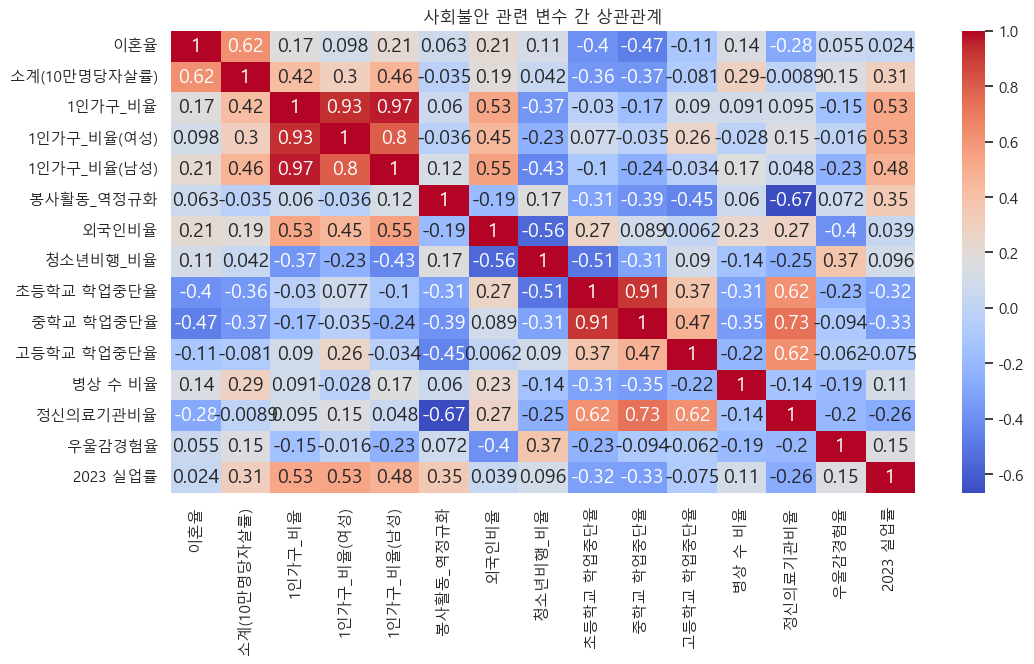

In [14]:
# 상관계수 히트맵
sns.heatmap(df_norm3[['이혼율', '소계(10만명당자살률)', '1인가구_비율', 
                      '1인가구_비율(여성)' , '1인가구_비율(남성)','봉사활동_역정규화', 
                      '외국인비율','청소년비행_비율', '초등학교 학업중단율', '중학교 학업중단율', 
                      '고등학교 학업중단율','병상 수 비율','정신의료기관비율', '우울감경험율', '2023 실업률']].corr(), 
            annot=True, cmap='coolwarm')
plt.title('사회불안 관련 변수 간 상관관계')
plt.show()

- 1인가구 관련 변수들 셋 중 하나만 남기고 나머지를 제거한다. 

- 학업 중단율은 초등학교와 중학교는 너무 유사하다. 중학교 학업중단율 하나만 쓰거나 중학교와 고등학교만 선택한다. 

- 정신의료기관 비율이 높은 지역은 청소년 학업 중단율, 자살률이 모두 높은 경향이 있다. 이는 지역 내 정신적·사회적 취약성이 높을 가능성을 시사한다.

- 병상 수 비율은 정신의료기관과 연동은 강하지만, 나머지 사회적 변수와는 낮은 상관관계를 가졌다. 병상 수 비율은 단일 변수로써 사회불안을 강하게 설명하지 못함

- 따라서 초등학교와 1인가구비율 남녀각각을 지운다. 
- 봉사활동_역정규화의 값은 높아질 수록 봉사활동 참여율이 저조하다는 것을 나타내는데 봉사활동을 "적게 한다" → 사회적 참여 부족 → 사회불안 증가 → 사회불안 지표들과 양의 상관관계 이런 결과를 기대했지만 봉사 적음 ↔ 사회불안 낮음이라는 모순된 결과가 나왔고 봉사활동 데이터 자체가 사회불안과 관계 없음이라는 결론을 내리고 사회불안지수에서 삭제한다.

In [15]:
# 피어슨 상관계수 확인
r, p = pearsonr(df_norm3['사회불안지수'], df_norm3['총범죄율'])
print(f"상관계수 (r): {r:.2f}, p-value: {p:.4f}")

r, p = pearsonr(df_norm3['사회불안지수'], df_norm3['강력범죄율'])
print(f"상관계수 (r): {r:.2f}, p-value: {p:.4f}")

KeyError: '사회불안지수'

### 상관계수 시각화

#### 피어슨

In [ ]:
variables = ['이혼율', '소계(10만명당자살률)', '1인가구_비율', 
                      '1인가구_비율(여성)' , '1인가구_비율(남성)','봉사활동_역정규화', 
                      '외국인비율','청소년비행_비율', '초등학교 학업중단율', '중학교 학업중단율', 
                      '고등학교 학업중단율','병상 수 비율','정신의료기관비율', '우울감경험율', '2023 실업률']

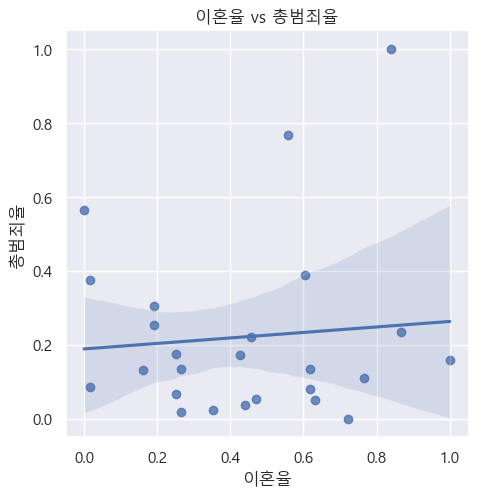

▶️ 이혼율 vs 총범죄율
  - 상관계수 (r): 0.086
  - 상관 p-value: 0.6830
  - 회귀계수 (slope): 0.074
  - 결정계수 (R²): 0.007
  - 회귀계수 p-value: 0.6830
--------------------------------------------------


C:\Users\admin\AppData\Local\Temp\ipykernel_21612\3962725847.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'  - 회귀계수 (slope): {model.params[1]:.3f}')
C:\Users\admin\AppData\Local\Temp\ipykernel_21612\3962725847.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'  - 회귀계수 p-value: {model.pvalues[1]:.4f}')


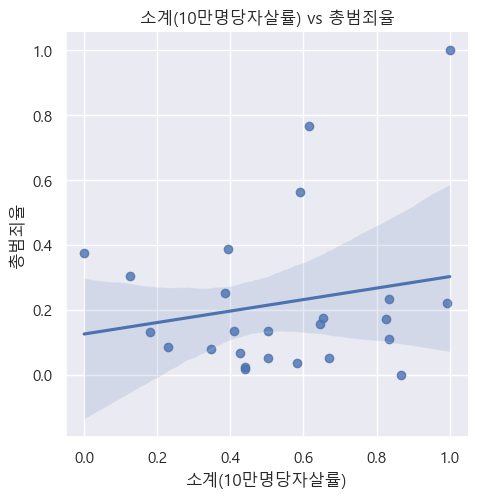

▶️ 소계(10만명당자살률) vs 총범죄율
  - 상관계수 (r): 0.192
  - 상관 p-value: 0.3591
  - 회귀계수 (slope): 0.177
  - 결정계수 (R²): 0.037
  - 회귀계수 p-value: 0.3591
--------------------------------------------------


C:\Users\admin\AppData\Local\Temp\ipykernel_21612\3962725847.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'  - 회귀계수 (slope): {model.params[1]:.3f}')
C:\Users\admin\AppData\Local\Temp\ipykernel_21612\3962725847.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'  - 회귀계수 p-value: {model.pvalues[1]:.4f}')


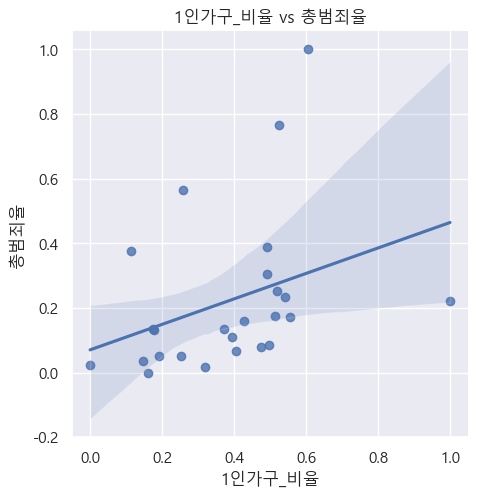

▶️ 1인가구_비율 vs 총범죄율
  - 상관계수 (r): 0.344
  - 상관 p-value: 0.0925
  - 회귀계수 (slope): 0.394
  - 결정계수 (R²): 0.118
  - 회귀계수 p-value: 0.0925
--------------------------------------------------


C:\Users\admin\AppData\Local\Temp\ipykernel_21612\3962725847.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'  - 회귀계수 (slope): {model.params[1]:.3f}')
C:\Users\admin\AppData\Local\Temp\ipykernel_21612\3962725847.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'  - 회귀계수 p-value: {model.pvalues[1]:.4f}')


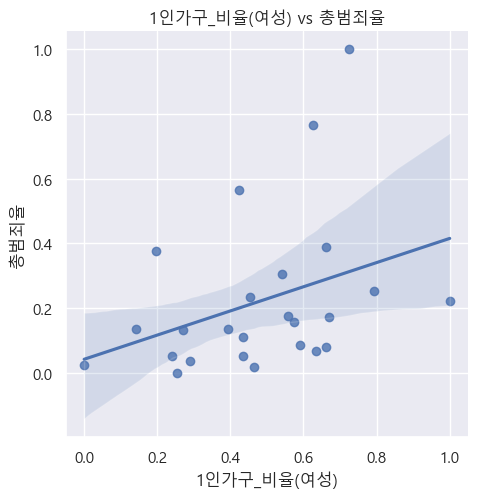

▶️ 1인가구_비율(여성) vs 총범죄율
  - 상관계수 (r): 0.350
  - 상관 p-value: 0.0862
  - 회귀계수 (slope): 0.374
  - 결정계수 (R²): 0.123
  - 회귀계수 p-value: 0.0862
--------------------------------------------------


C:\Users\admin\AppData\Local\Temp\ipykernel_21612\3962725847.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'  - 회귀계수 (slope): {model.params[1]:.3f}')
C:\Users\admin\AppData\Local\Temp\ipykernel_21612\3962725847.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'  - 회귀계수 p-value: {model.pvalues[1]:.4f}')


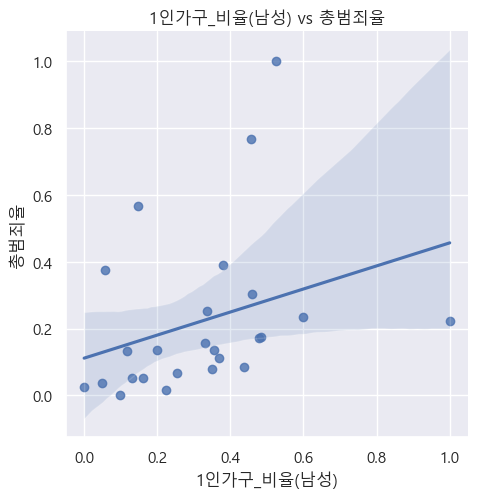

▶️ 1인가구_비율(남성) vs 총범죄율
  - 상관계수 (r): 0.311
  - 상관 p-value: 0.1301
  - 회귀계수 (slope): 0.344
  - 결정계수 (R²): 0.097
  - 회귀계수 p-value: 0.1301
--------------------------------------------------


C:\Users\admin\AppData\Local\Temp\ipykernel_21612\3962725847.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'  - 회귀계수 (slope): {model.params[1]:.3f}')
C:\Users\admin\AppData\Local\Temp\ipykernel_21612\3962725847.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'  - 회귀계수 p-value: {model.pvalues[1]:.4f}')


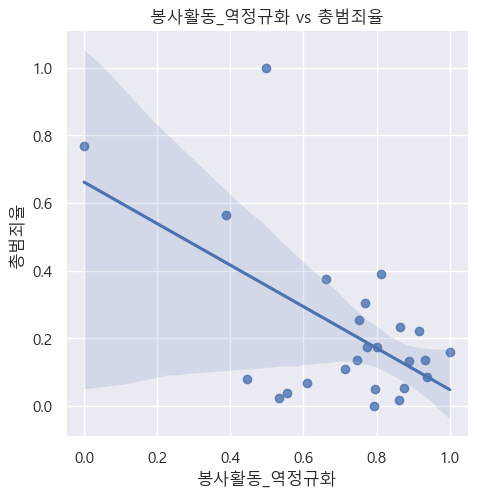

▶️ 봉사활동_역정규화 vs 총범죄율
  - 상관계수 (r): -0.558
  - 상관 p-value: 0.0037
  - 회귀계수 (slope): -0.614
  - 결정계수 (R²): 0.312
  - 회귀계수 p-value: 0.0037
--------------------------------------------------


C:\Users\admin\AppData\Local\Temp\ipykernel_21612\3962725847.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'  - 회귀계수 (slope): {model.params[1]:.3f}')
C:\Users\admin\AppData\Local\Temp\ipykernel_21612\3962725847.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'  - 회귀계수 p-value: {model.pvalues[1]:.4f}')


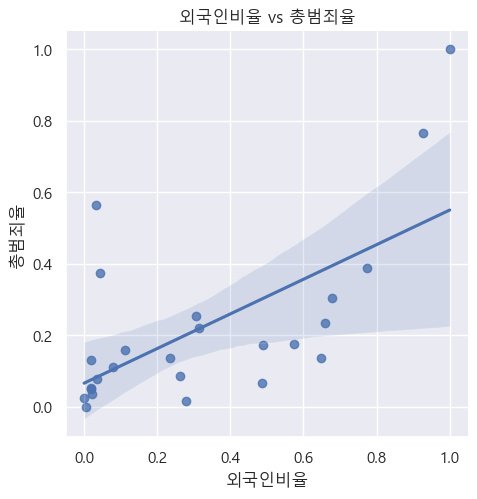

▶️ 외국인비율 vs 총범죄율
  - 상관계수 (r): 0.636
  - 상관 p-value: 0.0006
  - 회귀계수 (slope): 0.484
  - 결정계수 (R²): 0.404
  - 회귀계수 p-value: 0.0006
--------------------------------------------------


C:\Users\admin\AppData\Local\Temp\ipykernel_21612\3962725847.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'  - 회귀계수 (slope): {model.params[1]:.3f}')
C:\Users\admin\AppData\Local\Temp\ipykernel_21612\3962725847.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'  - 회귀계수 p-value: {model.pvalues[1]:.4f}')


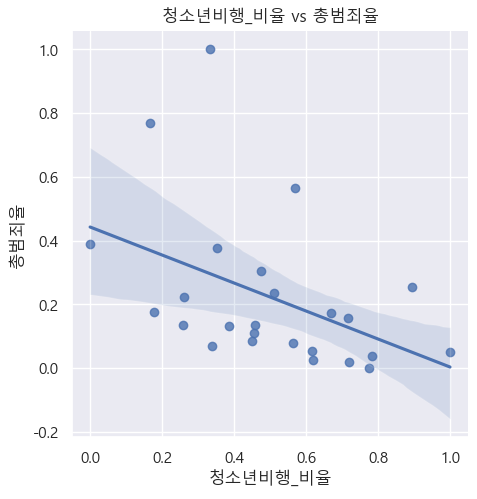

▶️ 청소년비행_비율 vs 총범죄율
  - 상관계수 (r): -0.438
  - 상관 p-value: 0.0284
  - 회귀계수 (slope): -0.440
  - 결정계수 (R²): 0.192
  - 회귀계수 p-value: 0.0284
--------------------------------------------------


C:\Users\admin\AppData\Local\Temp\ipykernel_21612\3962725847.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'  - 회귀계수 (slope): {model.params[1]:.3f}')
C:\Users\admin\AppData\Local\Temp\ipykernel_21612\3962725847.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'  - 회귀계수 p-value: {model.pvalues[1]:.4f}')


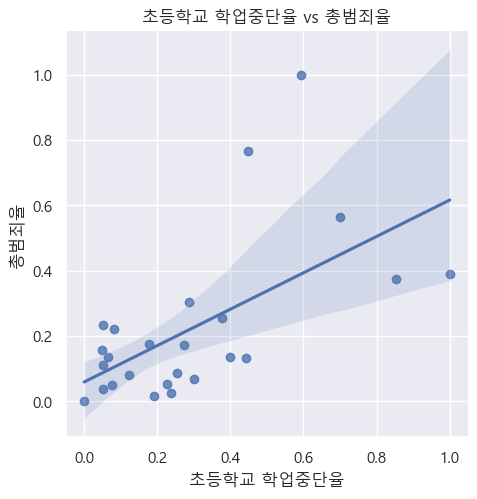

▶️ 초등학교 학업중단율 vs 총범죄율
  - 상관계수 (r): 0.604
  - 상관 p-value: 0.0014
  - 회귀계수 (slope): 0.557
  - 결정계수 (R²): 0.365
  - 회귀계수 p-value: 0.0014
--------------------------------------------------


C:\Users\admin\AppData\Local\Temp\ipykernel_21612\3962725847.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'  - 회귀계수 (slope): {model.params[1]:.3f}')
C:\Users\admin\AppData\Local\Temp\ipykernel_21612\3962725847.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'  - 회귀계수 p-value: {model.pvalues[1]:.4f}')


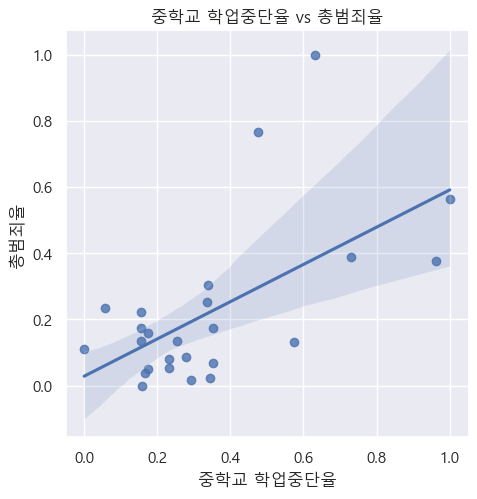

▶️ 중학교 학업중단율 vs 총범죄율
  - 상관계수 (r): 0.597
  - 상관 p-value: 0.0016
  - 회귀계수 (slope): 0.563
  - 결정계수 (R²): 0.356
  - 회귀계수 p-value: 0.0016
--------------------------------------------------


C:\Users\admin\AppData\Local\Temp\ipykernel_21612\3962725847.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'  - 회귀계수 (slope): {model.params[1]:.3f}')
C:\Users\admin\AppData\Local\Temp\ipykernel_21612\3962725847.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'  - 회귀계수 p-value: {model.pvalues[1]:.4f}')


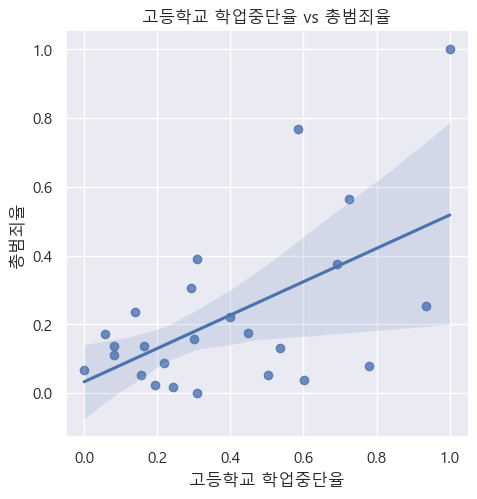

▶️ 고등학교 학업중단율 vs 총범죄율
  - 상관계수 (r): 0.562
  - 상관 p-value: 0.0035
  - 회귀계수 (slope): 0.486
  - 결정계수 (R²): 0.316
  - 회귀계수 p-value: 0.0035
--------------------------------------------------


C:\Users\admin\AppData\Local\Temp\ipykernel_21612\3962725847.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'  - 회귀계수 (slope): {model.params[1]:.3f}')
C:\Users\admin\AppData\Local\Temp\ipykernel_21612\3962725847.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'  - 회귀계수 p-value: {model.pvalues[1]:.4f}')


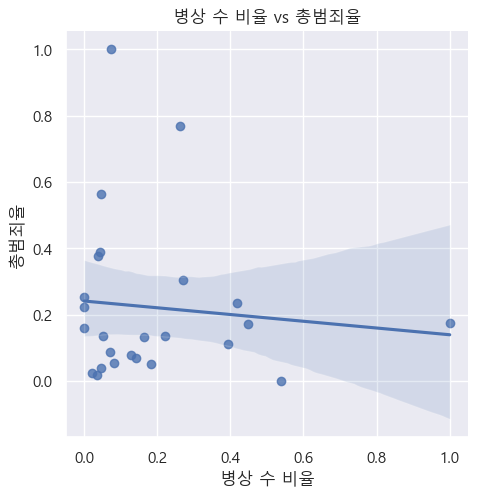

▶️ 병상 수 비율 vs 총범죄율
  - 상관계수 (r): -0.096
  - 상관 p-value: 0.6466
  - 회귀계수 (slope): -0.102
  - 결정계수 (R²): 0.009
  - 회귀계수 p-value: 0.6466
--------------------------------------------------


C:\Users\admin\AppData\Local\Temp\ipykernel_21612\3962725847.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'  - 회귀계수 (slope): {model.params[1]:.3f}')
C:\Users\admin\AppData\Local\Temp\ipykernel_21612\3962725847.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'  - 회귀계수 p-value: {model.pvalues[1]:.4f}')


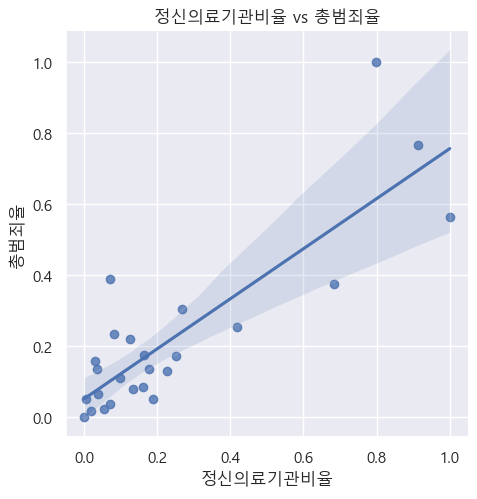

▶️ 정신의료기관비율 vs 총범죄율
  - 상관계수 (r): 0.848
  - 상관 p-value: 0.0000
  - 회귀계수 (slope): 0.704
  - 결정계수 (R²): 0.719
  - 회귀계수 p-value: 0.0000
--------------------------------------------------


C:\Users\admin\AppData\Local\Temp\ipykernel_21612\3962725847.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'  - 회귀계수 (slope): {model.params[1]:.3f}')
C:\Users\admin\AppData\Local\Temp\ipykernel_21612\3962725847.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'  - 회귀계수 p-value: {model.pvalues[1]:.4f}')


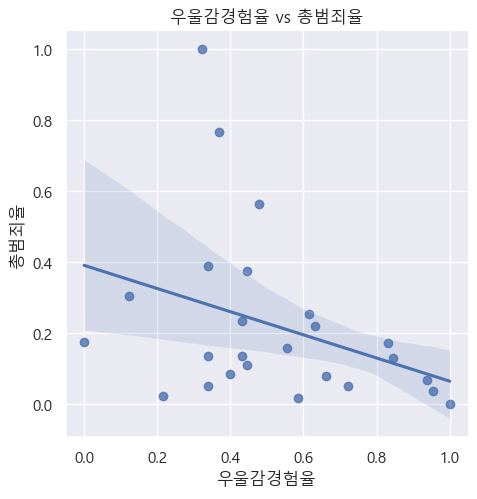

▶️ 우울감경험율 vs 총범죄율
  - 상관계수 (r): -0.349
  - 상관 p-value: 0.0875
  - 회귀계수 (slope): -0.326
  - 결정계수 (R²): 0.122
  - 회귀계수 p-value: 0.0875
--------------------------------------------------


C:\Users\admin\AppData\Local\Temp\ipykernel_21612\3962725847.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'  - 회귀계수 (slope): {model.params[1]:.3f}')
C:\Users\admin\AppData\Local\Temp\ipykernel_21612\3962725847.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'  - 회귀계수 p-value: {model.pvalues[1]:.4f}')


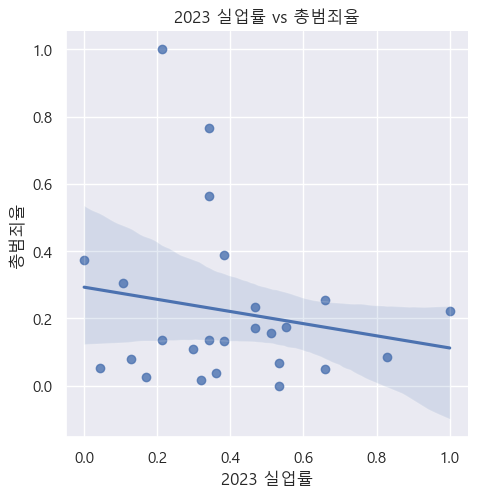

▶️ 2023 실업률 vs 총범죄율
  - 상관계수 (r): -0.178
  - 상관 p-value: 0.3957
  - 회귀계수 (slope): -0.181
  - 결정계수 (R²): 0.032
  - 회귀계수 p-value: 0.3957
--------------------------------------------------


C:\Users\admin\AppData\Local\Temp\ipykernel_21612\3962725847.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'  - 회귀계수 (slope): {model.params[1]:.3f}')
C:\Users\admin\AppData\Local\Temp\ipykernel_21612\3962725847.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'  - 회귀계수 p-value: {model.pvalues[1]:.4f}')


In [ ]:
for var in variables:
    # 산점도 + 회귀선 시각화
    sns.lmplot(data=df_norm3, x=var, y='총범죄율')
    plt.title(f'{var} vs 총범죄율')
    plt.show()
    
    # 회귀 수치 계산
    x = df_norm3[var]
    y = df_norm3['총범죄율']
    
    # 상관계수
    r, p_corr = stats.pearsonr(x, y)
    
    # statsmodels로 R², 회귀계수, p-value 확인
    x_with_const = sm.add_constant(x)
    model = sm.OLS(y, x_with_const).fit()
    
    print(f'▶️ {var} vs 총범죄율')
    print(f'  - 상관계수 (r): {r:.3f}')
    print(f'  - 상관 p-value: {p_corr:.4f}')
    print(f'  - 회귀계수 (slope): {model.params[1]:.3f}')
    print(f'  - 결정계수 (R²): {model.rsquared:.3f}')
    print(f'  - 회귀계수 p-value: {model.pvalues[1]:.4f}')
    print('-'*50)


#### 스피어맨

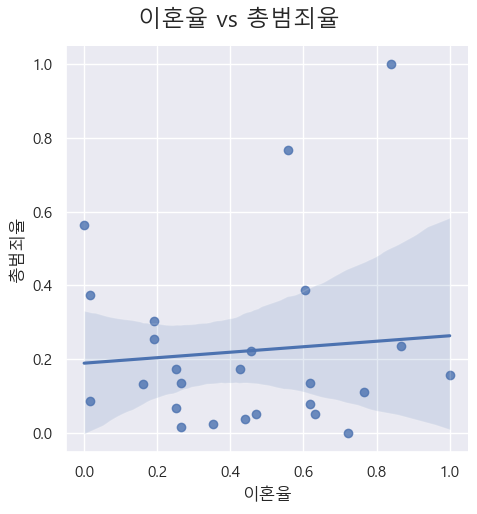

▶️ 이혼율 vs 총범죄율
  - 스피어만 상관계수 (r): -0.104
  - 상관 p-value: 0.6223
  - 회귀계수 (slope): 0.074
  - 결정계수 (R²): 0.007
  - 회귀계수 p-value: 0.6830
----------


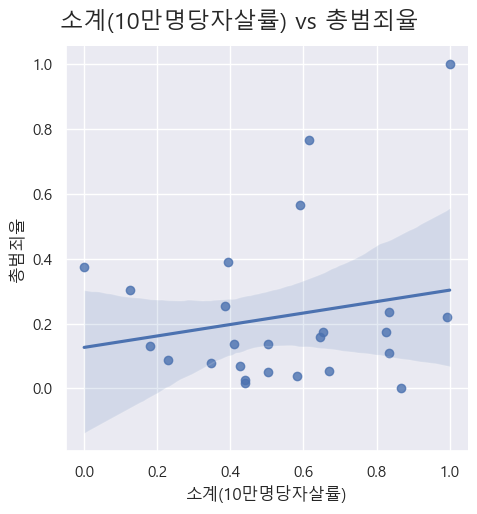

▶️ 소계(10만명당자살률) vs 총범죄율
  - 스피어만 상관계수 (r): 0.025
  - 상관 p-value: 0.9055
  - 회귀계수 (slope): 0.177
  - 결정계수 (R²): 0.037
  - 회귀계수 p-value: 0.3591
----------


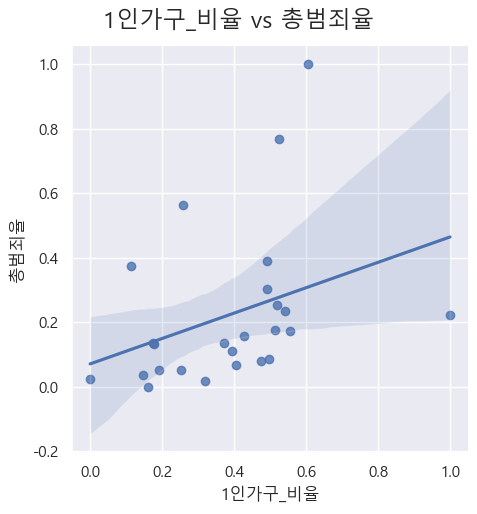

▶️ 1인가구_비율 vs 총범죄율
  - 스피어만 상관계수 (r): 0.578
  - 상관 p-value: 0.0025
  - 회귀계수 (slope): 0.394
  - 결정계수 (R²): 0.118
  - 회귀계수 p-value: 0.0925
----------


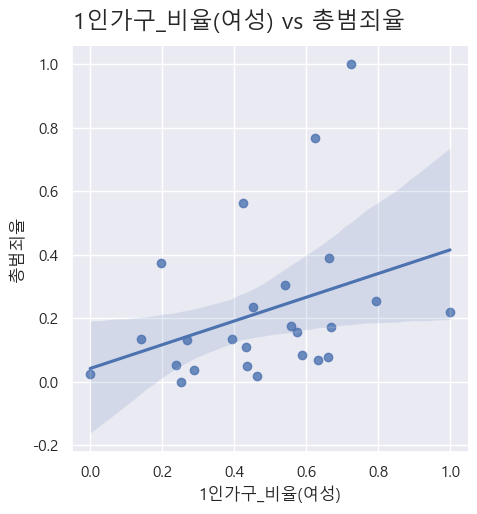

▶️ 1인가구_비율(여성) vs 총범죄율
  - 스피어만 상관계수 (r): 0.435
  - 상관 p-value: 0.0296
  - 회귀계수 (slope): 0.374
  - 결정계수 (R²): 0.123
  - 회귀계수 p-value: 0.0862
----------


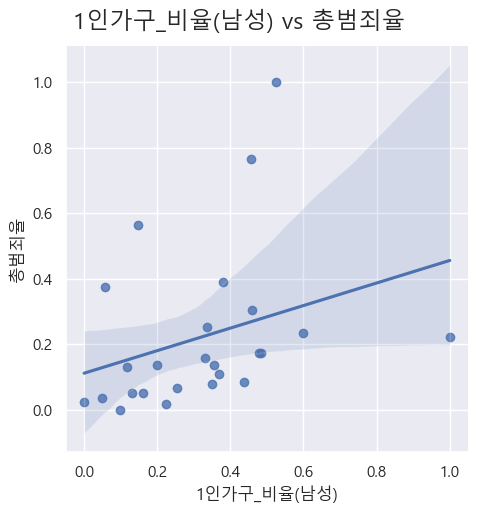

▶️ 1인가구_비율(남성) vs 총범죄율
  - 스피어만 상관계수 (r): 0.558
  - 상관 p-value: 0.0038
  - 회귀계수 (slope): 0.344
  - 결정계수 (R²): 0.097
  - 회귀계수 p-value: 0.1301
----------


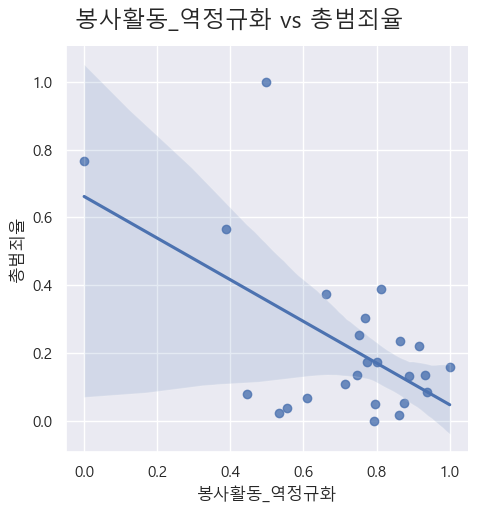

▶️ 봉사활동_역정규화 vs 총범죄율
  - 스피어만 상관계수 (r): -0.190
  - 상관 p-value: 0.3630
  - 회귀계수 (slope): -0.614
  - 결정계수 (R²): 0.312
  - 회귀계수 p-value: 0.0037
----------


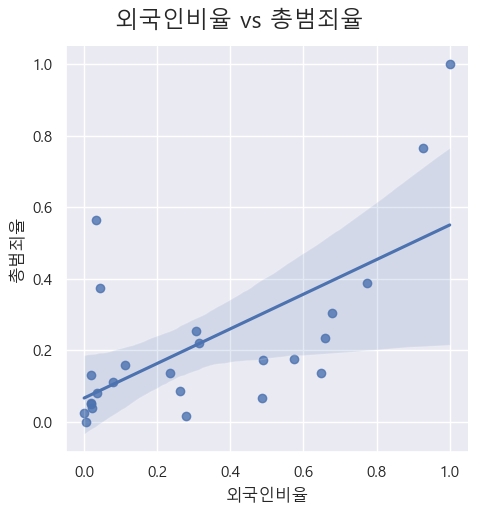

▶️ 외국인비율 vs 총범죄율
  - 스피어만 상관계수 (r): 0.675
  - 상관 p-value: 0.0002
  - 회귀계수 (slope): 0.484
  - 결정계수 (R²): 0.404
  - 회귀계수 p-value: 0.0006
----------


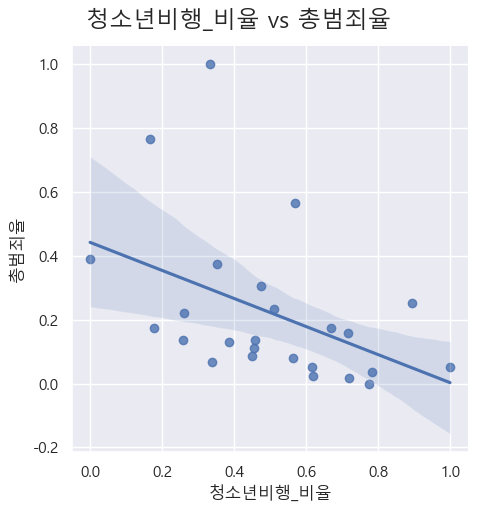

▶️ 청소년비행_비율 vs 총범죄율
  - 스피어만 상관계수 (r): -0.540
  - 상관 p-value: 0.0053
  - 회귀계수 (slope): -0.440
  - 결정계수 (R²): 0.192
  - 회귀계수 p-value: 0.0284
----------


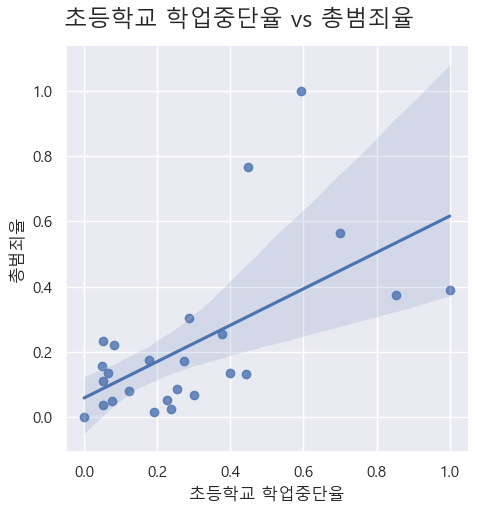

▶️ 초등학교 학업중단율 vs 총범죄율
  - 스피어만 상관계수 (r): 0.598
  - 상관 p-value: 0.0016
  - 회귀계수 (slope): 0.557
  - 결정계수 (R²): 0.365
  - 회귀계수 p-value: 0.0014
----------


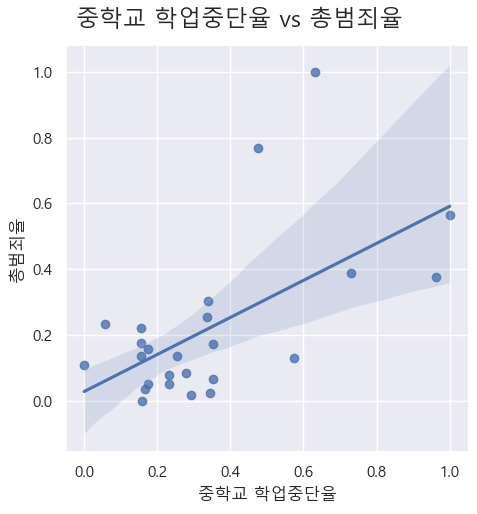

▶️ 중학교 학업중단율 vs 총범죄율
  - 스피어만 상관계수 (r): 0.426
  - 상관 p-value: 0.0336
  - 회귀계수 (slope): 0.563
  - 결정계수 (R²): 0.356
  - 회귀계수 p-value: 0.0016
----------


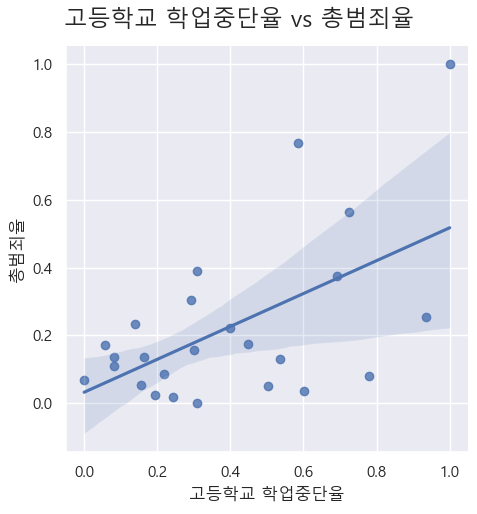

▶️ 고등학교 학업중단율 vs 총범죄율
  - 스피어만 상관계수 (r): 0.363
  - 상관 p-value: 0.0747
  - 회귀계수 (slope): 0.486
  - 결정계수 (R²): 0.316
  - 회귀계수 p-value: 0.0035
----------


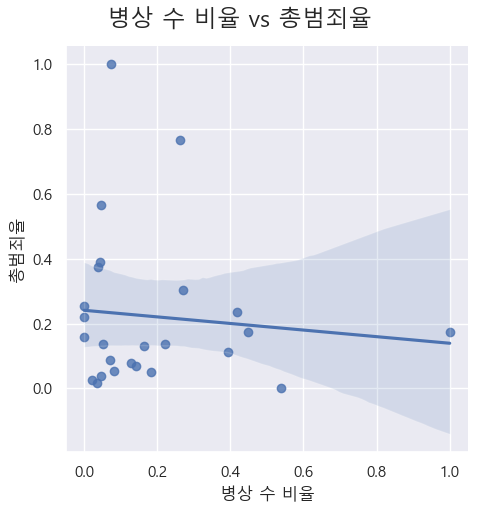

▶️ 병상 수 비율 vs 총범죄율
  - 스피어만 상관계수 (r): -0.040
  - 상관 p-value: 0.8493
  - 회귀계수 (slope): -0.102
  - 결정계수 (R²): 0.009
  - 회귀계수 p-value: 0.6466
----------


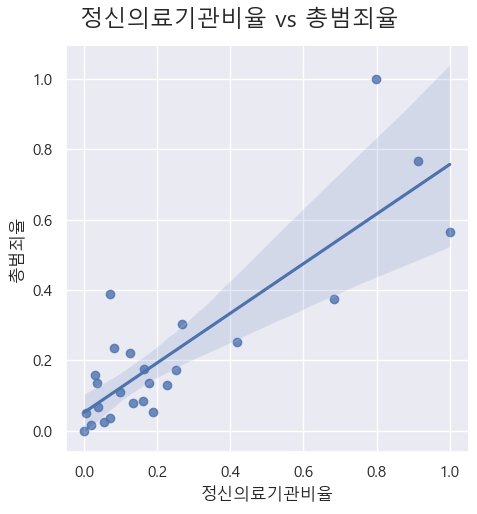

▶️ 정신의료기관비율 vs 총범죄율
  - 스피어만 상관계수 (r): 0.727
  - 상관 p-value: 0.0000
  - 회귀계수 (slope): 0.704
  - 결정계수 (R²): 0.719
  - 회귀계수 p-value: 0.0000
----------


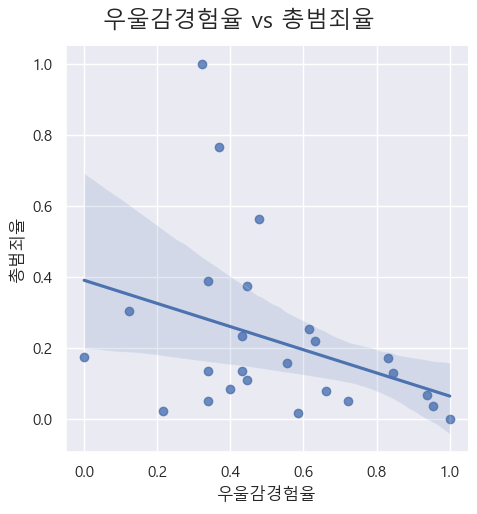

▶️ 우울감경험율 vs 총범죄율
  - 스피어만 상관계수 (r): -0.416
  - 상관 p-value: 0.0385
  - 회귀계수 (slope): -0.326
  - 결정계수 (R²): 0.122
  - 회귀계수 p-value: 0.0875
----------


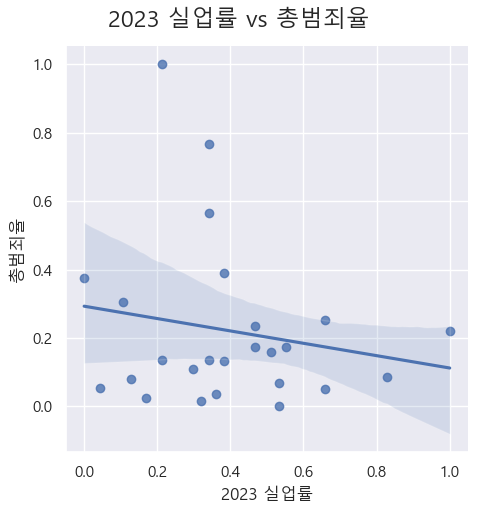

▶️ 2023 실업률 vs 총범죄율
  - 스피어만 상관계수 (r): -0.079
  - 상관 p-value: 0.7076
  - 회귀계수 (slope): -0.181
  - 결정계수 (R²): 0.032
  - 회귀계수 p-value: 0.3957
----------


In [ ]:
for var in variables:
    # 산점도 + 회귀선 시각화
    g = sns.lmplot(data=df_norm3, x=var, y='총범죄율')
    g.fig.suptitle(f'{var} vs 총범죄율', y=1.03)
    plt.show()

    x = df_norm3[var]
    y = df_norm3['총범죄율']

    # 상관계수: 스피어만
    r, p_corr = stats.spearmanr(x, y)

    # 회귀분석: statsmodels 선형 회귀
    x_with_const = sm.add_constant(x)
    model = sm.OLS(y, x_with_const).fit()

    # 출력
    print(f'▶️ {var} vs 총범죄율')
    print(f'  - 스피어만 상관계수 (r): {r:.3f}')
    print(f'  - 상관 p-value: {p_corr:.4f}')
    print(f'  - 회귀계수 (slope): {model.params.iloc[1]:.3f}')
    print(f'  - 결정계수 (R²): {model.rsquared:.3f}')
    print(f'  - 회귀계수 p-value: {model.pvalues.iloc[1]:.4f}')
    print('-'*10)


#### 다시 csv 내보내준다. 

In [ ]:
# csv로 내보낸다.
df_norm3.to_csv('members/조준혁/정규화_수정_진짜_최종.csv', encoding='utf-8-sig', index=True)

### 시각화

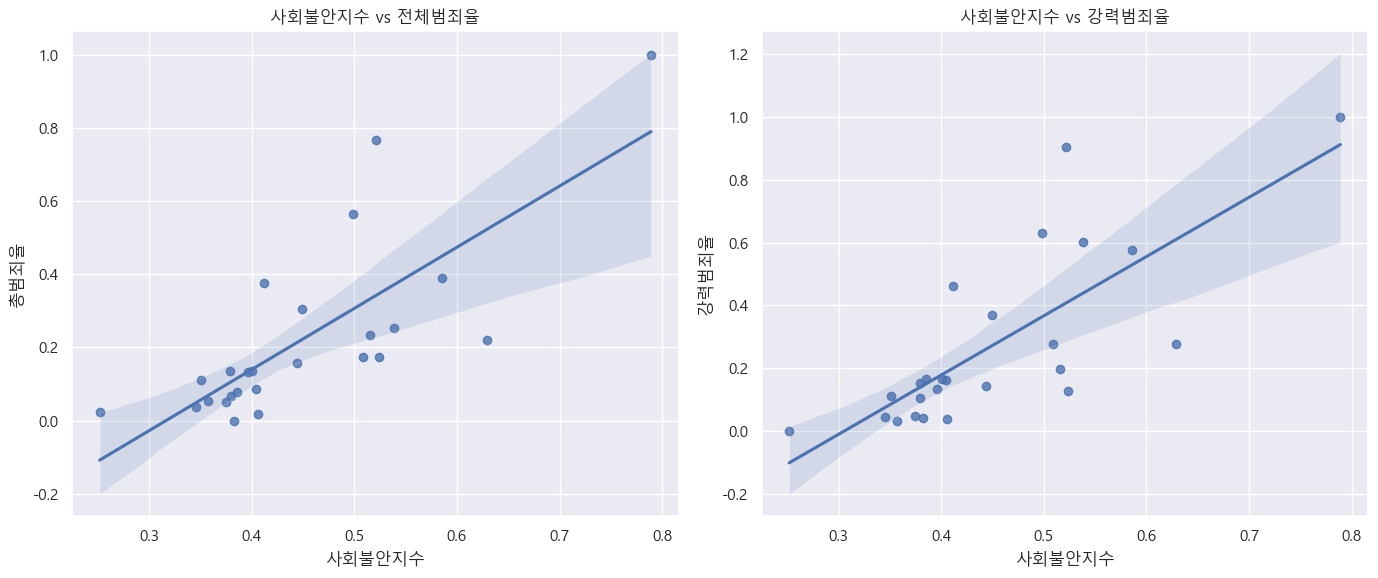

In [ ]:
# 회귀선 그리기

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 전체 범죄율
sns.regplot(data=df_norm3, x='사회불안지수', y='총범죄율', ax=axes[0])
axes[0].set_title('사회불안지수 vs 전체범죄율')

# 강력 범죄율
sns.regplot(data=df_norm3, x='사회불안지수', y='강력범죄율', ax=axes[1])
axes[1].set_title('사회불안지수 vs 강력범죄율')

plt.tight_layout()
plt.show()

In [ ]:

# 분석 대상 컬럼만
cols = [
    '이혼율', 
    '소계(10만명당자살률)', 
    '1인가구_비율',
    '봉사활동 등록률', 
    '외국인비율', 
    '청소년비행_비율',
    '중학교 학업중단율', 
    '정신의료기관비율'
]

# 해당 컬럼들만 추출
corr_df = df_norm3[cols].corr()

# 소수점 2자리로 반올림 (태블로에서 보기 좋게)
corr_df = corr_df.round(2)
corr_df.head()

,이혼율,소계(10만명당자살률),1인가구_비율,봉사활동 등록률,외국인비율,청소년비행_비율,중학교 학업중단율,정신의료기관비율
이혼율,1.00,0.62,0.17,-0.06,0.21,0.11,-0.47,-0.28
소계(10만명당자살률),0.62,1.00,0.42,0.04,0.19,0.04,-0.37,-0.01
1인가구_비율,0.17,0.42,1.00,-0.06,0.53,-0.37,-0.17,0.10
봉사활동 등록률,-0.06,0.04,-0.06,1.00,0.19,-0.17,0.39,0.67
외국인비율,0.21,0.19,0.53,0.19,1.00,-0.56,0.09,0.27


In [ ]:

# CSV로 저장
corr_df.to_csv('members/조준혁/사회불안_상관계수.csv', encoding='utf-8-sig')

**잔차(residuals)**의 정규성은 회귀분석에서 중요한 가정 중 하나이며
정규성이 없다면 회귀계수의 p-value와 신뢰구간 해석이 왜곡될 수 있다는 말을 들었기 때문에
스피어만 상관계수(Spearman’s ρ)**을 사용할 것임. 
스피어만 상관계수는 **데이터의 정규성(분포 형태)**을 전혀 가정하지 않는 비모수(non-parametric) 통계 기법입니다.